# RL and Advanced DL: Домашнее задание 2


In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

## Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

1) Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

2) Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.


### 1) Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

Берем среду для крестиков ноликов

In [8]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3


class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        
    def state_to_array(self):
        current = self.getState()[0]
        ans = list()
        for i in range(self.n_rows * self.n_cols):
            ans.append(int(current[i]))
            
        return ans

Не долго думая, написал агента для Q learning на основе 1 домашнего задания

In [28]:
import itertools

#env = TicTacToeEnv(symbols=[2, 0], board_size=3, win_size=3)

class Agent:
    def __init__(self, tag=1, symbols=[2, 0], board_size=3, win_size=3, alpha=0.1, gamma=0.9):
        self.alpha = alpha
        self.gamma = gamma
        self.tag = tag
        self.Q_table = defaultdict(lambda:1)
        self.board_size = board_size
        self.win_size = win_size
        stuff = [1]
        stuff.append(symbols[0])
        stuff.append(symbols[1])
        self.history = list()
        
        #for subset in tqdm(itertools.combinations_with_replacement(stuff, self.board_size * self.board_size)):
        #    if subset not in tqdm(self.Q_table.keys()):
        #        self.Q_table[subset] = 1
        #        for pos in tqdm(itertools.permutations(subset, self.board_size * self.board_size)):
        #            self.Q_table[pos] = 1     
                    
                    
    def get_action(self, state, action_area, eps):
        posible_states = dict()
        if np.random.random() < eps:
            next_action = np.random.choice(list(action_area))
            action_area.remove(next_action)
            new_state = state.copy()
            new_state[next_action] = self.tag
            self.history.append(tuple(new_state))
        else:        
            for i in range(len(state)):
                if state[i] == 1:
                    new_state = state.copy()
                    new_state[i] = self.tag
                    posible_states[tuple(new_state)] = self.Q_table[tuple(new_state)]

            next_action = list(max(posible_states, key=posible_states.get))#next_action = list(posible_states.keys())[np.argmax(max(posible_states, key=posible_states.get))]
        
            self.history.append(tuple(next_action))
            next_state = np.absolute(np.array(state) - np.array(next_action))

            next_action = np.argmax(next_state)
            action_area.remove(next_action)
        
        return next_action, action_area
    
    def update(self, reward):
        for i in reversed(self.history):
            reward = self.Q_table[i] + self.alpha * (reward - self.gamma * self.Q_table[i])
            self.Q_table[i] = reward
            
        self.history = list()
        

Функция для обучения

In [29]:
def sample_episode(env, agent_tic, agent_tac, eps_tic=0.2, eps_tac=0.2, render=True, batch_size=1):
    rews1 = list()
    rews2 = list()
    for i in range(batch_size):
        user = 0
        done = False
        reward = 0
        state = env.reset()
        action_area = set(np.arange(env.n_rows * env.n_cols))        
        while not done:
            if render:
                env.render(mode=None)
            if user == 0:
                state = env.state_to_array()
                #print(state, action_area)
                choice, action_area = agent_tic.get_action(state, action_area, eps_tic)
                state, reward, done, infos = env.step(env.action_from_int(choice))
            elif user == 1:   
                state = env.state_to_array()
                #print(state, action_area)
                choice, action_area = agent_tac.get_action(state, action_area, eps_tac)       
                state, reward, done, infos = env.step(env.action_from_int(choice))

            

            #print(reward)
            if not done:
                user = 0 if user == 1 else 1
            else :
                if reward == 0:
                    reward1 = 0.5
                    reward2 = 0.5
                    agent_tic.update(reward1)
                    agent_tac.update(reward2)

                elif reward == -1:
                    reward1 = -1
                    reward2 = 1
                    agent_tic.update(reward1)
                    agent_tac.update(reward2)

                elif reward == 1:
                    reward1 = 1
                    reward2 = -1
                    agent_tic.update(reward1)
                    agent_tac.update(reward2)
        
        rews1.append(reward1)
        rews2.append(reward2)
    
    return np.mean(rews1), np.mean(rews2)
        

In [30]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
env.reset()

In [31]:
agent_tic = Agent(tag=2) #-1
agent_tac = Agent(tag=0) #1

In [32]:
n_episodes = 20000



tic_rewards = list()
tac_rewards = list()

rews1 = list()
rews2 = list()

exploration_rate_tic = 1
exploration_rate_tac = 1

rew_cum1 = 0
rew_cum2 = 0
for i in tqdm(range(n_episodes)):
    
    if i % 100 == 0:
        exploration_rate_tic -= 0.01
        #exploration_rate_tac -= 0.01
    
    rew1, rew2 = sample_episode(env, agent_tic, agent_tac, exploration_rate_tic, exploration_rate_tac, render=False, batch_size=4)
    rew_cum1 += rew1
    rew_cum2 += rew2
    rews1.append(rew1)
    rews2.append(rew2)
    tic_rewards.append(rew_cum1 / (i+1))
    tac_rewards.append(rew_cum2 / (i+1))
    


График среднего выигрыша для крестиков против случайного выбора

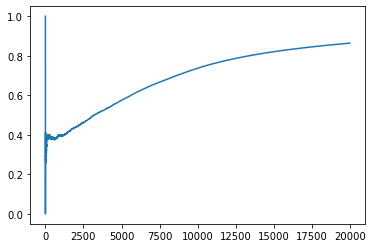

In [33]:
plt.plot(tic_rewards)

Теперь пробуем обучить играть ноликов против случайного соперника

In [16]:
agent_tic = Agent(tag=2) #-1
agent_tac = Agent(tag=0) #1

In [19]:
n_episodes = 50000



tic_rewards = list()
tac_rewards = list()

rews1 = list()
rews2 = list()

exploration_rate_tic = 1
exploration_rate_tac = 1

rew_cum1 = 0
rew_cum2 = 0
for i in tqdm(range(n_episodes)):
    
    if i % 100 == 0:
        #exploration_rate_tic -= 0.01
        exploration_rate_tac -= 0.01
    
    rew1, rew2 = sample_episode(env, agent_tic, agent_tac, exploration_rate_tic, exploration_rate_tac, render=False, batch_size=4)
    rew_cum1 += rew1
    rew_cum2 += rew2
    rews1.append(rew1)
    rews2.append(rew2)
    tic_rewards.append(rew_cum1 / (i+1))
    tac_rewards.append(rew_cum2 / (i+1))
    


График среднего выигрыша для ноликов

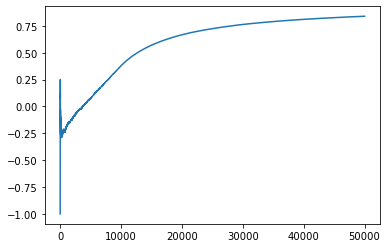

In [20]:
plt.plot(tac_rewards)

### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Попробуем обучить для доски 4x4

In [22]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
env.reset()
agent_tic = Agent(tag=2, symbols=[2, 0], board_size=4, win_size=4, alpha=0.1, gamma=0.9) #-1
agent_tac = Agent(tag=0, symbols=[2, 0], board_size=4, win_size=4, alpha=0.1, gamma=0.9) #1

In [25]:
n_episodes = 100000



tic_rewards = list()
tac_rewards = list()

rews1 = list()
rews2 = list()

exploration_rate_tic = 1
exploration_rate_tac = 1

rew_cum1 = 0
rew_cum2 = 0
for i in tqdm(range(n_episodes)):
    
    if i % 100 == 0:
        exploration_rate_tic -= 0.01
        #exploration_rate_tac -= 0.01
    
    rew1, rew2 = sample_episode(env, agent_tic, agent_tac, exploration_rate_tic, exploration_rate_tac, render=False, batch_size=4)
    rew_cum1 += rew1
    rew_cum2 += rew2
    rews1.append(rew1)
    rews2.append(rew2)
    tic_rewards.append(rew_cum1 / (i+1))
    tac_rewards.append(rew_cum2 / (i+1))
    


Средний выигрыш для крестиков против случайного соперника на доске 4x4

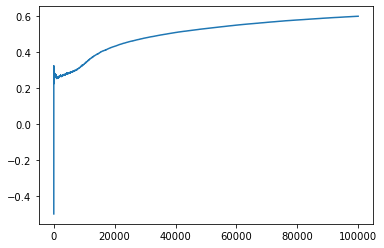

In [26]:
plt.plot(tic_rewards)

Теперь обучим для доски 5x5

In [27]:
env = TicTacToe(n_rows=5, n_cols=5, n_win=5)
env.reset()
agent_tic = Agent(tag=2, symbols=[2, 0], board_size=5, win_size=5, alpha=0.1, gamma=0.9) #-1
agent_tac = Agent(tag=0, symbols=[2, 0], board_size=5, win_size=5, alpha=0.1, gamma=0.9) #1

In [28]:
n_episodes = 100000



tic_rewards = list()
tac_rewards = list()

rews1 = list()
rews2 = list()

exploration_rate_tic = 1
exploration_rate_tac = 1

rew_cum1 = 0
rew_cum2 = 0
for i in tqdm(range(n_episodes)):
    
    if i % 100 == 0:
        exploration_rate_tic -= 0.01
        #exploration_rate_tac -= 0.01
    
    rew1, rew2 = sample_episode(env, agent_tic, agent_tac, exploration_rate_tic, exploration_rate_tac, render=False, batch_size=4)
    rew_cum1 += rew1
    rew_cum2 += rew2
    rews1.append(rew1)
    rews2.append(rew2)
    tic_rewards.append(rew_cum1 / (i+1))
    tac_rewards.append(rew_cum2 / (i+1))
    


Средний выигрыш для крестиков против случайного соперника на доске 5x5

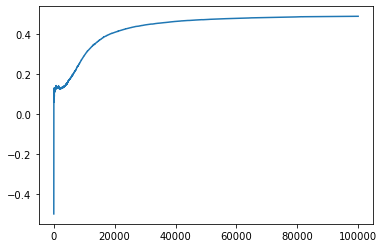

In [29]:
plt.plot(tic_rewards)

Если для доски 4 на 4 крестики имели средний выигрыш 0.6 (за победу 1) на 100к эпизодов, то на доске 5 на 5 средний выигрыш уже около 0.4. Такого количества эпизодов не хватает для того, чтобы агент сошелся

## Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

1) Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

2) Реализуйте Double DQN и/или Dueling DQN.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
from collections import deque

### 1) Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

Реализуем сеть DQN и агента с experience replay. Experience replay построим на основе collections.deque, он позволяет задать максимальную длину и сам зациклится и будет - как раз это и нужно, а тут работает из коробки

In [7]:
BUF_SIZE = 512
N_COLS_ROWS_WINS = 3

class DQN(nn.Module):
    def __init__(self, dim=512, kernel_size=(3,3), n_channels=N_COLS_ROWS_WINS, out_channels=N_COLS_ROWS_WINS * N_COLS_ROWS_WINS):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=dim, kernel_size=kernel_size)
        self.fc1 = nn.Linear(dim, dim * 2)
        self.fc2 = nn.Linear(dim * 2, dim)
        self.fc3 = nn.Linear(dim, out_channels)     
        
    def forward(self, x):
        x = F.relu(self.conv1(x)).squeeze(-1).squeeze(-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return self.fc3(x)
    

class DQN_Agent:
    def __init__(self, size, kernel_size=(3,3), n_channels=N_COLS_ROWS_WINS, out_channels=N_COLS_ROWS_WINS * N_COLS_ROWS_WINS):
        self.size = size
        self.replay_buffer = deque(maxlen=BUF_SIZE)
        self.state = None
        self.next_state = None
        self.action = None
        self.reward = None
        self.model = DQN()
        self.optim = optim.Adam(self.model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    
    def update_replay(self, transition):
        self.replay_buffer.append((transition[0], transition[1], transition[2], transition[3]))
        
    def sample(self, batch_size):
        return random.sample(self.replay_buffer, batch_size)
    
    def update(self, next_state, action, reward):
        next_state_ = np.zeros((3,N_COLS_ROWS_WINS,N_COLS_ROWS_WINS))
        next_state_[0,:,:] = (next_state == 1).astype(float)
        next_state_[1,:,:] = (next_state == -1).astype(float)
        next_state_[2,:,:] = (next_state == 0).astype(float)
        if self.state is not None:
            self.update_replay((self.state, next_state_, self.action, reward))
            
        self.state = next_state_
        self.action = action
        
        
        
    
    

Будем опять обучать играть агентов против случайного соперника

In [13]:
import random  
from IPython import display
from ipywidgets import Output


env = TicTacToe(n_rows=N_COLS_ROWS_WINS, n_cols=N_COLS_ROWS_WINS, n_win=N_COLS_ROWS_WINS)    
LR = 1e-6
WEIGHT_DECAY = 1e-9
HIDDEN_SIZE = 512
batch_size = 128
criterion = F.l1_loss

tic_agent = DQN_Agent(size=HIDDEN_SIZE, n_channels=3, out_channels=N_COLS_ROWS_WINS*N_COLS_ROWS_WINS)
tac_agent = DQN_Agent(size=HIDDEN_SIZE, n_channels=3, out_channels=N_COLS_ROWS_WINS*N_COLS_ROWS_WINS)

n_epochs = 10000

def DQN_train(env, tic_agent, tac_agent, criterion, n_epochs):
    rews1 = list()
    rews2 = list()

    rew_cum1 = 0
    rew_cum2 = 0

    eps = 0.5
    gamma = 0.9

    history_rews1 = list()
    history_rews2 = list()
    y_rews = list()

    out = Output()
    display.display(out)
    for i in tqdm(range(n_epochs)):

        env.reset()
        tic_agent.model.eval()
        tac_agent.model.eval()
        game_hash, empty_spaces, turn = env.getState()
        state = env.board.copy()

        user = 0
        done=False

        tic_agent.state = None
        tic_agent.action = None

        tac_agent.state = None
        tac_agent.action = None

        #Сэмплируем эпизод
        while not done:
            if random.random() < (1 - eps):
                state_ = np.zeros((3,N_COLS_ROWS_WINS,N_COLS_ROWS_WINS))
                state_[0,:,:] = (state == 1).astype(float)
                state_[1,:,:] = (state == -1).astype(float)
                state_[2,:,:] = (state == 0).astype(float)
                state_ = torch.FloatTensor([state_])
                if user == 0:
                    #tic_agent.model.eval()
                    action = tic_agent.model(state_).detach().max(1)[1][0].item()

                else:
                    #tac_agent.model.eval()
                    action = tac_agent.model(state_).detach().max(1)[1][0].item()                

            else:
                possible_states = np.where(np.array(list(game_hash)) == '1')[0]
                action = random.choice(possible_states)

            if user == 0:
                tic_agent.update(state, action, 0)
            else:
                tac_agent.update(state, action, 0)       

            (game_hash, empty_spaces, turn), reward , done, _ = env.step(env.action_from_int(action))
            state = env.board.copy()     

            if not done:
                user = 0 if user == 1 else 1    

        #Добавляем опыт в experience replay
        if reward == -10:
            if user == 0:
                tic_agent.update(state, action, reward)
            else:
                tac_agent.update(state, action, reward)
        else:    
            tic_agent.update(state, action, reward)
            tac_agent.update(state, action, -reward)               

        
        #Будем обновлять только с того момента, как наш буффер заполнится. На самом деле здесь можно было поступить по другому
        #и изначально насэмплировать буффер на необученном агенте
        if len(tic_agent.replay_buffer) >= batch_size:
            states, next_states, actions, rewards = list(zip(*tic_agent.sample(batch_size)))


            batch_state = torch.FloatTensor(states)
            batch_next_state = torch.FloatTensor(next_states)
            batch_actions = torch.LongTensor(actions)
            batch_reward = torch.FloatTensor(rewards)

            tic_agent.model.train()
            Q = tic_agent.model(batch_state).gather(1, batch_actions.view(-1, 1)).flatten()
            Qmax = tic_agent.model(batch_next_state).detach().max(dim=1)[0]
            Qnext = batch_reward + (gamma * Qmax)

            loss = criterion(Q, Qnext)


            loss.backward()
            tic_agent.optim.step()
            tic_agent.optim.zero_grad()   

            rews1.append(loss.item())

        if len(tac_agent.replay_buffer) >= batch_size:
            states, next_states, actions, rewards = list(zip(*tac_agent.sample(batch_size)))


            batch_state = torch.FloatTensor(states)
            batch_next_state = torch.FloatTensor(next_states)
            batch_actions = torch.LongTensor(actions)
            batch_reward = torch.FloatTensor(rewards)

            tac_agent.model.train()
            Q = tac_agent.model(batch_state).gather(1, batch_actions.view(-1, 1)).flatten()
            Qmax = tac_agent.model(batch_next_state).detach().max(dim=1)[0]
            Qnext = batch_reward + (gamma * Qmax)

            loss = criterion(Q, Qnext)


            loss.backward()
            tac_agent.optim.step()
            tac_agent.optim.zero_grad()   

            rews2.append(loss.item())
        
        #Попробуем сыграть по очереди за крестиков и за ноликов
        if (i + 1) % 100 == 0:

            tic_agent.model.eval()
            tac_agent.model.eval()

            rews1 = list()
            rews2 = list()

            n_hands = 128

            for j in range(n_hands):
                env.reset()
                game_hash, empty_spaces, turn = env.getState()
                state = env.board
                done = False        
                user = 0

                while not done:
                    if user == 0:
                        state_ = np.zeros((3,N_COLS_ROWS_WINS,N_COLS_ROWS_WINS))
                        state_[0,:,:] = (state == 1).astype(float)
                        state_[1,:,:] = (state == -1).astype(float)
                        state_[2,:,:] = (state == 0).astype(float)                    
                        state_ = torch.FloatTensor([state_])
                        action = tic_agent.model(state_).detach().max(1)[1][0].item()
                    else:
                        possible_states = np.where(np.array(list(game_hash)) == '1')[0]
                        action = random.choice(possible_states) 

                    (game_hash, empty_spaces, turn), reward , done, _ = env.step(env.action_from_int(action))
                    state = env.board.copy()     

                    if not done:
                        user = 0 if user == 1 else 1    

                if reward == -1 or reward == -10:
                    reward = 0

                rews1.append(reward)

                env.reset()
                game_hash, empty_spaces, turn = env.getState()
                state = env.board
                done = False        
                user = 0

                while not done:
                    if user == 1:
                        state_ = np.zeros((3,N_COLS_ROWS_WINS,N_COLS_ROWS_WINS))
                        state_[0,:,:] = (state == 1).astype(float)
                        state_[1,:,:] = (state == -1).astype(float)
                        state_[2,:,:] = (state == 0).astype(float)                    
                        state_ = torch.FloatTensor([state_])
                        action = tac_agent.model(state_).detach().max(1)[1][0].item()
                    else:
                        possible_states = np.where(np.array(list(game_hash)) == '1')[0]
                        action = random.choice(possible_states) 

                    (game_hash, empty_spaces, turn), reward , done, _ = env.step(env.action_from_int(action))
                    state = env.board.copy() 
                    reward *= -1

                    if not done:
                        user = 0 if user == 1 else 1    

                if reward == -1 or reward == 10:
                    reward = 0
                

                rews2.append(reward)  

            #if np.mean(rews1) > 0 or np.mean(rews2) > 0:
            #    print(np.mean(rews1), np.mean(rews2))

            history_rews1.append(np.mean(rews1))
            history_rews2.append(np.mean(rews2))
            y_rews.append(i)
            with out:
                display.clear_output(wait=True)
                plt.title("DQN, iteration " + str(i))
                plt.plot(y_rews, history_rews1, label='tic')
                plt.plot(y_rews, history_rews2, label='tac')
                plt.legend()
                plt.draw()
                plt.pause(0.05)
    
    return history_rews1, history_rews2, y_rews

In [14]:
tic_agent.model

DQN(
  (conv1): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=9, bias=True)
)

In [15]:
rews1, rews2, y_rews = DQN_train(env, tic_agent, tac_agent, criterion, n_epochs)

Output()

Крестики против случайного соперника

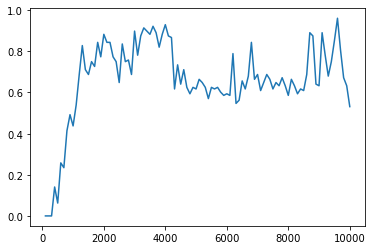

In [20]:
plt.plot(y_rews, rews1)

Нолики против случайного соперника

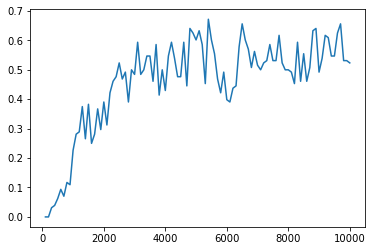

In [19]:
plt.plot(y_rews, rews2)

Попробуем обучить агентов для доски 4x4

In [21]:
N_COLS_ROWS_WINS = 4

class DQN(nn.Module):
    def __init__(self, dim_1=32, dim_2=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=dim_1, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=dim_1, out_channels=dim_2, kernel_size=(2, 2))
        self.fc1 = nn.Linear(dim_2, dim_2 * 2)
        self.fc2 = nn.Linear(dim_2 * 2, dim_2 * 2)
        self.fc3 = nn.Linear(dim_2 * 2, N_COLS_ROWS_WINS * N_COLS_ROWS_WINS)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x)).squeeze(-1).squeeze(-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return self.fc3(x) 

In [22]:
tic_agent.model

DQN(
  (conv1): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=9, bias=True)
)

In [23]:
env = TicTacToe(n_rows=N_COLS_ROWS_WINS, n_cols=N_COLS_ROWS_WINS, n_win=N_COLS_ROWS_WINS)    
LR = 1e-5
WEIGHT_DECAY = 1e-9
HIDDEN_SIZE = 512
batch_size = 128
criterion = F.l1_loss

tic_agent = DQN_Agent(size=HIDDEN_SIZE, n_channels=3, out_channels=N_COLS_ROWS_WINS*N_COLS_ROWS_WINS)
tac_agent = DQN_Agent(size=HIDDEN_SIZE, n_channels=3, out_channels=N_COLS_ROWS_WINS*N_COLS_ROWS_WINS)

n_epochs = 10000

rews1, rews2, y_rews = DQN_train(env, tic_agent, tac_agent, criterion, n_epochs)

Output()

Крестики про случайного соперника

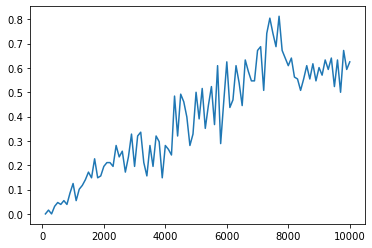

In [24]:
plt.plot(y_rews, rews1)

Нолики против случайного соперника

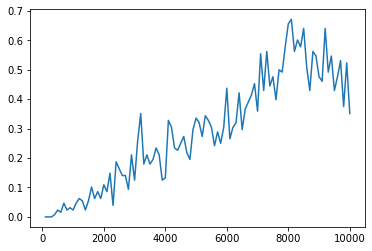

In [25]:
plt.plot(y_rews, rews2)

### 2. Реализуйте Double DQN и/или Dueling DQN.

Реализуем Dueling DQN, для этого нам понадобится 2 сети: первая будет считать Value function, а вторая Advantage.

In [26]:
N_COLS_ROWS_WINS = 3

class Value(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return F.relu(self.fc3(x))
    
class Advantage(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, N_COLS_ROWS_WINS * N_COLS_ROWS_WINS)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return F.relu(self.fc3(x))


class DQN(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=(3, 3))  
        self.value = Value()
        self.advantage = Advantage()
        
        
    def forward(self, x):
        x = F.relu(self.conv(x)).squeeze(-1).squeeze(-1)
        advantage = self.advantage(x)
        value = self.value(x)
        return value + (advantage - advantage.mean(dim=1, keepdim=True).expand(x.size(0), N_COLS_ROWS_WINS * N_COLS_ROWS_WINS))

In [27]:
env = TicTacToe(n_rows=N_COLS_ROWS_WINS, n_cols=N_COLS_ROWS_WINS, n_win=N_COLS_ROWS_WINS)    
LR = 1e-5
WEIGHT_DECAY = 1e-9
HIDDEN_SIZE = 512
batch_size = 128
criterion = F.l1_loss

tic_agent = DQN_Agent(size=HIDDEN_SIZE, n_channels=3, out_channels=N_COLS_ROWS_WINS*N_COLS_ROWS_WINS)
tac_agent = DQN_Agent(size=HIDDEN_SIZE, n_channels=3, out_channels=N_COLS_ROWS_WINS*N_COLS_ROWS_WINS)

n_epochs = 10000

rews1, rews2, y_rews = DQN_train(env, tic_agent, tac_agent, criterion, n_epochs)

Output()

Крестики против случайного соперника

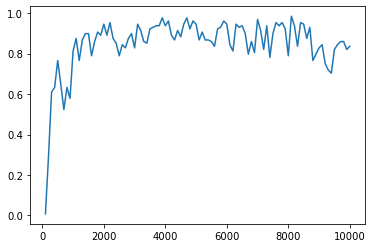

In [28]:
plt.plot(y_rews, rews1)

Нолики против случайного соперника

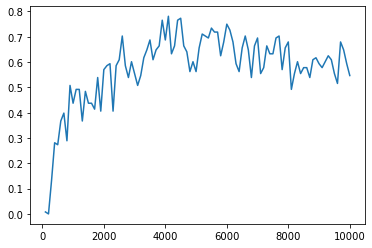

In [29]:
plt.plot(y_rews, rews2)

Попробуем обучить Double DQN. Для этого в агента добавим target-сеть. Теперь максимум Q будем считать через нее. Target-сеть будем обновлять каждые N_UPDATE иттераций с помощью функции update_target_network

In [35]:
class DQN_Agent:
    def __init__(self, size, kernel_size=(3,3), n_channels=N_COLS_ROWS_WINS, out_channels=N_COLS_ROWS_WINS * N_COLS_ROWS_WINS):
        self.size = size
        self.replay_buffer = deque(maxlen=BUF_SIZE)
        self.state = None
        self.next_state = None
        self.action = None
        self.reward = None
        self.model = DQN()
        self.target_model = DQN()
        self.optim = optim.Adam(self.model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    
    def update_replay(self, transition):
        self.replay_buffer.append((transition[0], transition[1], transition[2], transition[3]))
        
    def sample(self, batch_size):
        return random.sample(self.replay_buffer, batch_size)
    
    def update(self, next_state, action, reward):
        next_state_ = np.zeros((3,N_COLS_ROWS_WINS,N_COLS_ROWS_WINS))
        next_state_[0,:,:] = (next_state == 1).astype(float)
        next_state_[1,:,:] = (next_state == -1).astype(float)
        next_state_[2,:,:] = (next_state == 0).astype(float)
        if self.state is not None:
            self.update_replay((self.state, next_state_, self.action, reward))
            
        self.state = next_state_
        self.action = action
        
    def update_target_network(self):
        for target_param, local_param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_(local_param.data)
        

In [42]:
import random  
from IPython import display
from ipywidgets import Output


env = TicTacToe(n_rows=N_COLS_ROWS_WINS, n_cols=N_COLS_ROWS_WINS, n_win=N_COLS_ROWS_WINS)
N_UPDATE = 4
LR = 1e-6
WEIGHT_DECAY = 1e-9
HIDDEN_SIZE = 512
batch_size = 128
criterion = F.l1_loss

tic_agent = DQN_Agent(size=HIDDEN_SIZE, n_channels=3, out_channels=N_COLS_ROWS_WINS*N_COLS_ROWS_WINS)
tac_agent = DQN_Agent(size=HIDDEN_SIZE, n_channels=3, out_channels=N_COLS_ROWS_WINS*N_COLS_ROWS_WINS)

n_epochs = 10000

def DQN_train(env, tic_agent, tac_agent, criterion, n_epochs):
    rews1 = list()
    rews2 = list()

    rew_cum1 = 0
    rew_cum2 = 0

    eps = 0.5
    gamma = 0.9

    history_rews1 = list()
    history_rews2 = list()
    y_rews = list()

    out = Output()
    display.display(out)
    for i in tqdm(range(n_epochs)):

        env.reset()
        tic_agent.model.eval()
        tac_agent.model.eval()
        game_hash, empty_spaces, turn = env.getState()
        state = env.board.copy()

        user = 0
        done=False

        tic_agent.state = None
        tic_agent.action = None

        tac_agent.state = None
        tac_agent.action = None

        #Сэмплируем эпизод
        while not done:
            if random.random() < (1 - eps):
                state_ = np.zeros((3,N_COLS_ROWS_WINS,N_COLS_ROWS_WINS))
                state_[0,:,:] = (state == 1).astype(float)
                state_[1,:,:] = (state == -1).astype(float)
                state_[2,:,:] = (state == 0).astype(float)
                state_ = torch.FloatTensor([state_])
                if user == 0:
                    #tic_agent.model.eval()
                    action = tic_agent.model(state_).detach().max(1)[1][0].item()

                else:
                    #tac_agent.model.eval()
                    action = tac_agent.model(state_).detach().max(1)[1][0].item()                

            else:
                possible_states = np.where(np.array(list(game_hash)) == '1')[0]
                action = random.choice(possible_states)

            if user == 0:
                tic_agent.update(state, action, 0)
            else:
                tac_agent.update(state, action, 0)       

            (game_hash, empty_spaces, turn), reward , done, _ = env.step(env.action_from_int(action))
            state = env.board.copy()     

            if not done:
                user = 0 if user == 1 else 1    

        #Добавляем опыт в experience replay
        if reward == -10:
            if user == 0:
                tic_agent.update(state, action, reward)
            else:
                tac_agent.update(state, action, reward)
        else:    
            tic_agent.update(state, action, reward)
            tac_agent.update(state, action, -reward)               

        
        #Будем обновлять только с того момента, как наш буффер заполнится. На самом деле здесь можно было поступить по другому
        #и изначально насэмплировать буффер на необученном агенте
        if len(tic_agent.replay_buffer) >= batch_size:
            states, next_states, actions, rewards = list(zip(*tic_agent.sample(batch_size)))


            batch_state = torch.FloatTensor(states)
            batch_next_state = torch.FloatTensor(next_states)
            batch_actions = torch.LongTensor(actions)
            batch_reward = torch.FloatTensor(rewards)
            #Теперь считаем Q как обычно, а Qmax через target-сеть
            tic_agent.model.train()
            Q = tic_agent.model(batch_state).gather(1, batch_actions.view(-1, 1)).flatten()
            Qmax = tic_agent.target_model(batch_next_state).detach().max(dim=1)[0]
            Qnext = batch_reward + (gamma * Qmax)

            loss = criterion(Q, Qnext)


            loss.backward()
            tic_agent.optim.step()
            tic_agent.optim.zero_grad()   

            rews1.append(loss.item())
            
            #Каждые четыре итерации обновляем пораметры target-сети
            if i % N_UPDATE == 0:
                tic_agent.update_target_network()

        if len(tac_agent.replay_buffer) >= batch_size:
            states, next_states, actions, rewards = list(zip(*tac_agent.sample(batch_size)))


            batch_state = torch.FloatTensor(states)
            batch_next_state = torch.FloatTensor(next_states)
            batch_actions = torch.LongTensor(actions)
            batch_reward = torch.FloatTensor(rewards)

            tac_agent.model.train()
            Q = tac_agent.model(batch_state).gather(1, batch_actions.view(-1, 1)).flatten()
            Qmax = tac_agent.target_model(batch_next_state).detach().max(dim=1)[0]
            Qnext = batch_reward + (gamma * Qmax)

            loss = criterion(Q, Qnext)


            loss.backward()
            tac_agent.optim.step()
            tac_agent.optim.zero_grad()   

            rews2.append(loss.item())
            
            if i % N_UPDATE == 0:
                tac_agent.update_target_network()        
        #Попробуем сыграть по очереди за крестиков и за ноликов
        if (i + 1) % 100 == 0:

            tic_agent.model.eval()
            tac_agent.model.eval()

            rews1 = list()
            rews2 = list()

            n_hands = 128

            for j in range(n_hands):
                env.reset()
                game_hash, empty_spaces, turn = env.getState()
                state = env.board
                done = False        
                user = 0

                while not done:
                    if user == 0:
                        state_ = np.zeros((3,N_COLS_ROWS_WINS,N_COLS_ROWS_WINS))
                        state_[0,:,:] = (state == 1).astype(float)
                        state_[1,:,:] = (state == -1).astype(float)
                        state_[2,:,:] = (state == 0).astype(float)                    
                        state_ = torch.FloatTensor([state_])
                        action = tic_agent.model(state_).detach().max(1)[1][0].item()
                    else:
                        possible_states = np.where(np.array(list(game_hash)) == '1')[0]
                        action = random.choice(possible_states) 

                    (game_hash, empty_spaces, turn), reward , done, _ = env.step(env.action_from_int(action))
                    state = env.board.copy()     

                    if not done:
                        user = 0 if user == 1 else 1    

                if reward == -1 or reward == -10:
                    reward = 0

                rews1.append(reward)

                env.reset()
                game_hash, empty_spaces, turn = env.getState()
                state = env.board
                done = False        
                user = 0

                while not done:
                    if user == 1:
                        state_ = np.zeros((3,N_COLS_ROWS_WINS,N_COLS_ROWS_WINS))
                        state_[0,:,:] = (state == 1).astype(float)
                        state_[1,:,:] = (state == -1).astype(float)
                        state_[2,:,:] = (state == 0).astype(float)                    
                        state_ = torch.FloatTensor([state_])
                        action = tac_agent.model(state_).detach().max(1)[1][0].item()
                    else:
                        possible_states = np.where(np.array(list(game_hash)) == '1')[0]
                        action = random.choice(possible_states) 

                    (game_hash, empty_spaces, turn), reward , done, _ = env.step(env.action_from_int(action))
                    state = env.board.copy() 
                    reward *= -1

                    if not done:
                        user = 0 if user == 1 else 1    

                if reward == -1 or reward == 10:
                    reward = 0
                

                rews2.append(reward)  

            #if np.mean(rews1) > 0 or np.mean(rews2) > 0:
            #    print(np.mean(rews1), np.mean(rews2))

            history_rews1.append(np.mean(rews1))
            history_rews2.append(np.mean(rews2))
            y_rews.append(i)
            with out:
                display.clear_output(wait=True)
                plt.title("DQN, iteration " + str(i))
                plt.plot(y_rews, history_rews1, label='tic')
                plt.plot(y_rews, history_rews2, label='tac')
                plt.legend()
                plt.draw()
                plt.pause(0.05)
    
    return history_rews1, history_rews2, y_rews

In [41]:
env = TicTacToe(n_rows=N_COLS_ROWS_WINS, n_cols=N_COLS_ROWS_WINS, n_win=N_COLS_ROWS_WINS)    
LR = 1e-5
WEIGHT_DECAY = 1e-9
HIDDEN_SIZE = 512
batch_size = 128
criterion = F.l1_loss

tic_agent = DQN_Agent(size=HIDDEN_SIZE, n_channels=3, out_channels=N_COLS_ROWS_WINS*N_COLS_ROWS_WINS)
tac_agent = DQN_Agent(size=HIDDEN_SIZE, n_channels=3, out_channels=N_COLS_ROWS_WINS*N_COLS_ROWS_WINS)

n_epochs = 10000

rews1, rews2, y_rews = DQN_train(env, tic_agent, tac_agent, criterion, n_epochs)

Output()

Крестики против случайного соперника

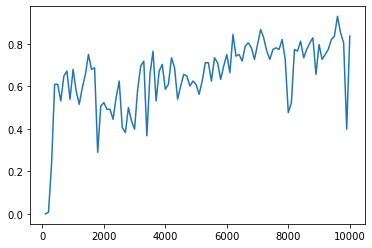

In [43]:
plt.plot(y_rews, rews1)

Нолики против случайного соперника

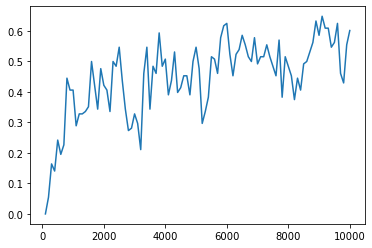

In [44]:
plt.plot(y_rews, rews2)

## Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.

5) Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

6) Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.


### 5) Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

Реализуем Агента с rollouts

In [47]:
from copy import deepcopy

N_ROLLOUTS = 16

class Agent_Rollouts(Agent):
    def get_action(self, env, action_area):
        tmp_env = deepcopy(env)
        rewards = dict()
        user = 0
        for i in list(action_area):
            entry_point_env = deepcopy(tmp_env)
            state, reward, done, infos = entry_point_env.step(entry_point_env.action_from_int(i))
            if not done:
                res = list()
                for j in range(N_ROLLOUTS):
                    eval_user = 1
                    evaluate_env = deepcopy(entry_point_env)
                    eval_action_area = deepcopy(action_area)                    
                    eval_action_area.remove(i)
                    eval_done = False
                
                    while eval_done == False:
                        eval_next_action = np.random.choice(list(eval_action_area))
                        eval_action_area.remove(eval_next_action)      
                        eval_state, eval_reward, eval_done, _ = evaluate_env.step(evaluate_env.action_from_int(eval_next_action))
                
                        if not eval_done:
                            eval_user = 0 if eval_user == 1 else 1
                
                    if eval_user == 0:
                        res.append(eval_reward)
                    else:
                        res.append(-eval_reward)

                rewards[i] = np.mean(res)
                    
            #print(i)
            #entry_point_state.printBoard()
            else:
                rewards[i] = reward
        return max(rewards, key=rewards.get)
        

In [48]:
def sample_episode(env, agent, n_batches=32):
    rewards = list()
    for i in range(n_batches):
        env.reset()
        state = env.state_to_array()
        action_area = set(np.arange(env.n_rows * env.n_cols)) 

        user = 0
        done = False
        while not done:
            if user == 0:
                next_action = agent.get_action(env, action_area)
                action_area.remove(next_action)
                state, reward, done, infos = env.step(env.action_from_int(next_action))
                #env.printBoard()

            else:
                next_action = np.random.choice(list(action_area))
                action_area.remove(next_action)   
                state, reward, done, infos = env.step(env.action_from_int(next_action))
                #env.printBoard()

            if not done:
                user = 0 if user == 1 else 1    
            else:
                #if reward == 0:
                #    reward = 0.5
            
                rewards.append(reward)

    return np.mean(rewards)

In [26]:
n_episodes = 1000
N_COLS_ROWS_WINS = 3
env = TicTacToe(n_rows=N_COLS_ROWS_WINS, n_cols=N_COLS_ROWS_WINS, n_win=N_COLS_ROWS_WINS)    

rews = list()
rews_cum = list()
rew_c = 0

statistics = defaultdict(int)
agent = Agent_Rollouts()

for i in tqdm(range(n_episodes)):
    
    rew = sample_episode(env, agent, n_batches=1)
    statistics[rew] += 1
    rew_c += rew

    rews.append(rew)
    rews_cum.append(rew_c / (i+1))

    
print('Победы: ', statistics[1] / n_episodes, ' Ничьи: ', statistics[0] / n_episodes, ' Поражения: ', statistics[-1] / n_episodes)


Победы:  0.752  Ничьи:  0.0  Поражения:  0.248


Крестики против случайного соперника

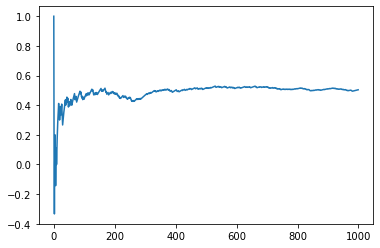

In [27]:
plt.plot(rews_cum)

Теперь попробуем реализовать rollout с использованием обученной q-функции

In [93]:
from copy import deepcopy

N_ROLLOUTS = 16

class Agent_Rollouts(Agent):
    def __init__(self, Q_table, tag):
        self.Q_table = Q_table
        self.tag = tag
        
    def get_action(self, env, action_area):
        tmp_env = deepcopy(env)
        rewards = dict()
        user = 0
        for i in list(action_area):
            entry_point_env = deepcopy(tmp_env)
            state, reward, done, infos = entry_point_env.step(entry_point_env.action_from_int(i))
            if not done:
                res = list()
                for j in range(N_ROLLOUTS):
                    
                    eval_user = 1
                    evaluate_env = deepcopy(entry_point_env)
                    eval_action_area = deepcopy(action_area)      
                    eval_state = state
                    eval_action_area.remove(i)
                    eval_done = False
                
                    while eval_done == False:
                        if eval_user == 0:
                            posible_states = dict()
                            eval_state = evaluate_env.state_to_array()
                            for k in range(len(eval_state)):
                                if eval_state[k] == 1:
                                    new_state = eval_state.copy()
                                    new_state[k] = self.tag
                                    posible_states[tuple(new_state)] = self.Q_table[tuple(new_state)]

                            next_action = list(max(posible_states, key=posible_states.get))#next_action = list(posible_states.keys())[np.argmax(max(posible_states, key=posible_states.get))]


                            next_state = np.absolute(np.array(eval_state) - np.array(next_action))
                           # print(eval_state)
                            eval_next_action = np.argmax(next_state)   
                        else:
                            eval_next_action = np.random.choice(list(eval_action_area))

                        eval_action_area.remove(eval_next_action)      
                        eval_state, eval_reward, eval_done, _ = evaluate_env.step(evaluate_env.action_from_int(eval_next_action))

                        if not eval_done:
                            eval_user = 0 if eval_user == 1 else 1
                
                    if eval_user == 0:
                        res.append(eval_reward)
                    else:
                        res.append(-eval_reward)

                rewards[i] = np.mean(res)
                    
            #print(i)
            #entry_point_state.printBoard()
            else:
                rewards[i] = reward
        return max(rewards, key=rewards.get)
        

In [96]:
n_episodes = 1000
N_COLS_ROWS_WINS = 3
env = TicTacToe(n_rows=N_COLS_ROWS_WINS, n_cols=N_COLS_ROWS_WINS, n_win=N_COLS_ROWS_WINS)    

rews = list()
rews_cum = list()
rew_c = 0

statistics = defaultdict(int)
agent = Agent_Rollouts(agent_tic.Q_table, 2)

for i in tqdm(range(n_episodes)):
    
    rew = sample_episode(env, agent, n_batches=1)
    statistics[rew] += 1
    rew_c += rew

    rews.append(rew)
    rews_cum.append(rew_c / (i+1))

    
print('Победы: ', statistics[1] / n_episodes, ' Ничьи: ', statistics[0] / n_episodes, ' Поражения: ', statistics[-1] / n_episodes)


Победы:  0.824  Ничьи:  0.002  Поражения:  0.174


Крестики c q-функцией против случайного соперника

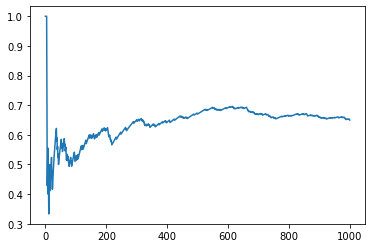

In [97]:
plt.plot(rews_cum)